In [400]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, top_k_accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

In [401]:
health_df = pd.read_excel('Data_Analytics_Take_Home_HL.xlsx')
health_df.columns = health_df.columns.str.strip().str.lower().str.replace(" ", "_")

# health_df.head()

In [402]:
health_df.info()
health_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   pageview_id             100000 non-null  object        
 1   user_id                 100000 non-null  object        
 2   known_diagnosis         99858 non-null   object        
 3   page_category           100000 non-null  object        
 4   device_type             100000 non-null  object        
 5   page_topic_description  100000 non-null  object        
 6   session_start_time      100000 non-null  datetime64[ns]
 7   asset_loaded_time       100000 non-null  datetime64[ns]
 8   time_of_day             100000 non-null  int64         
 9   return_visitor          100000 non-null  int64         
 10  asset_shown             100000 non-null  object        
 11  conversion              100000 non-null  int64         
dtypes: datetime64[ns](2), int64(3),

(100000, 12)

### It seems that the data is very clean with almost no errors.

In [403]:
# Look into the statistical summary of the categorical fields

health_df.select_dtypes("object").describe().T

,count,unique,top,freq
pageview_id,100000,100000,14afd810-bee0-4dde-984a-f36e5082cc13,1
user_id,100000,100000,00007820-89cb-4c1d-9940-eb270d605a35,1
known_diagnosis,99858,6,,88877
page_category,100000,5,nauseaandvomiting,36475
device_type,100000,3,mobile,33385
page_topic_description,100000,20,gastrointestinal_bleeding,9165
asset_shown,100000,3,A,55000


In [414]:
conversion_rates = health_df.groupby('asset_shown')['conversion'].mean()
print("Conversion Rates by Asset")
print(conversion_rates)

Conversion Rates by Asset
asset_shown
A    0.109655
B    0.071273
C    0.170571
Name: conversion, dtype: float64


In [404]:
health_df["conversion_status"] = health_df['conversion'].map({0: 'Not Converted', 1: 'Converted'})
health_df.head(5)

,pageview_id,user_id,known_diagnosis,page_category,device_type,page_topic_description,session_start_time,asset_loaded_time,time_of_day,return_visitor,asset_shown,conversion,conversion_status
0,14afd810-bee0-4dde-984a-f36e5082cc13,00007820-89cb-4c1d-9940-eb270d605a35,,nauseaandvomiting,tablet,abdominal_pain,2023-08-26 09:18:09.785,2023-08-26 09:19:00.025,9,0,B,0,Not Converted
1,264d4634-8b76-4043-aa6a-768225dba92b,00012b55-514c-421e-9c76-3300abbc1134,,nauseaandvomiting,mobile,abdominal_pain,2023-08-13 18:47:03.635,2023-08-13 18:48:01.275,18,0,B,0,Not Converted
2,8759fa0b-3596-4306-b46c-aa2303490211,000157c1-b6a3-4c86-82c7-9ec1bda3799a,Ulcerative Colitis,nauseaandvomiting,desktop,food_poisoning,2023-08-28 11:19:24.177,2023-08-28 11:20:04.347,11,0,A,0,Not Converted
3,287d4980-19be-4654-bdd0-344ab656bcc3,00020400-efab-4b10-8812-2a0aaf774841,,nauseaandvomiting,tablet,food_poisoning,2023-08-12 00:23:40.564,2023-08-12 00:24:11.854,0,1,A,0,Not Converted
4,4c6e84c5-448d-4211-a307-a1e26a34f8ea,0002f737-0cda-48fb-91ed-533f3d0eab05,,nauseaandvomiting,mobile,food_poisoning,2023-08-07 11:29:20.634,2023-08-07 11:30:02.834,11,0,A,0,Not Converted


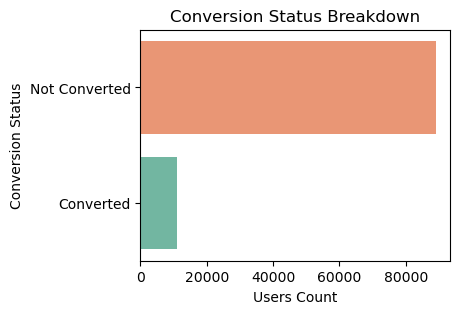

conversion
0    89.024
1    10.976
Name: proportion, dtype: float64


In [405]:

CSet2 = {'Converted':  sns.color_palette('Set2')[0], 'Not Converted': sns.color_palette('Set2')[1]}  # Adjust 'Not Converted' color as needed

# Create a column chart showing the count of Conversion status
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,3))
sns.countplot(y='conversion_status', data=health_df, ax=ax, palette=CSet2)
ax.set_ylabel("Conversion Status")
ax.set_xlabel("Users Count")
ax.set_title("Conversion Status Breakdown")
plt.show()

# Provide the percentage of cancel status
print(health_df.conversion.value_counts(normalize=True)*100)

### From the chart and summary, we can see that 10.98% of all visitors successfully converted and generated revenue for Healthline, while the rest of 89% did not.

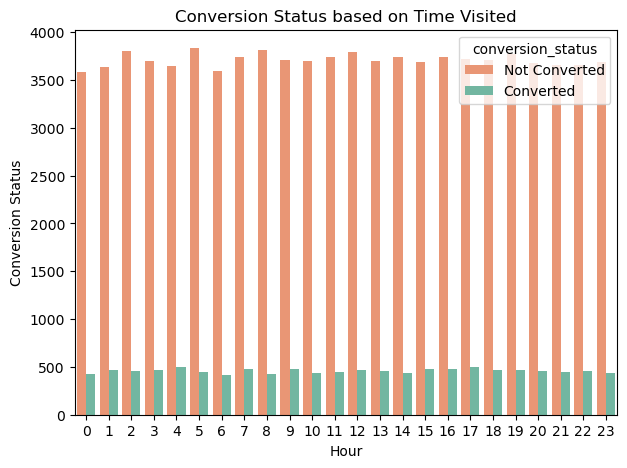

In [406]:
# Create a graph indicating conversion status based on time visited
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
sns.countplot(x='time_of_day', hue='conversion_status', data=health_df, ax=ax, palette=CSet2)
ax.set_title('Conversion Status based on Time Visited')
ax.set_xlabel('Hour')
ax.set_ylabel('Conversion Status')
plt.show()

### It seems that time of the day is not really a big factor in determining the conversion status (not a good predictor). But we need to actually verify that later.

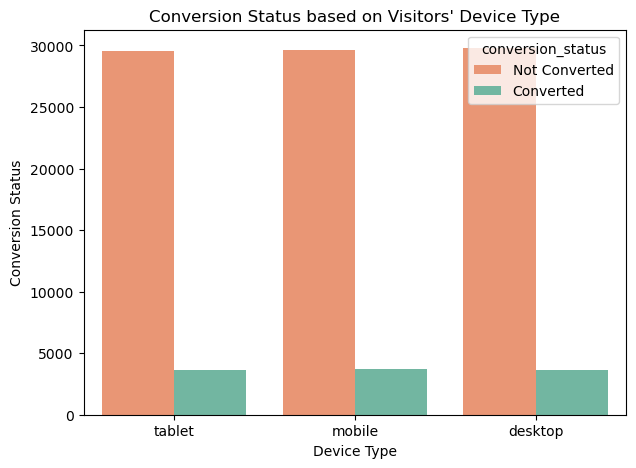

device_type
mobile     33385
desktop    33383
tablet     33232
Name: count, dtype: int64


In [407]:
# Create a graph indicating conversion status based on time visited
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
sns.countplot(x='device_type', hue='conversion_status', data=health_df, ax=ax, palette=CSet2)
ax.set_title('Conversion Status based on Visitors\' Device Type')
ax.set_xlabel('Device Type')
ax.set_ylabel('Conversion Status')
plt.show()
# Provide the count
print(health_df.device_type.value_counts())

### It seems clear that Device Type has no impact on the conversion as well.

In [408]:
health_df['session_start_time'] = pd.to_datetime(health_df['session_start_time'])
health_df['asset_loaded_time'] = pd.to_datetime(health_df['asset_loaded_time'])
health_df['time_spent'] = (health_df['asset_loaded_time'] - health_df['session_start_time']).dt.total_seconds()
health_df.head(5)

,pageview_id,user_id,known_diagnosis,page_category,device_type,page_topic_description,session_start_time,asset_loaded_time,time_of_day,return_visitor,asset_shown,conversion,conversion_status,time_spent
0,14afd810-bee0-4dde-984a-f36e5082cc13,00007820-89cb-4c1d-9940-eb270d605a35,,nauseaandvomiting,tablet,abdominal_pain,2023-08-26 09:18:09.785,2023-08-26 09:19:00.025,9,0,B,0,Not Converted,50.24
1,264d4634-8b76-4043-aa6a-768225dba92b,00012b55-514c-421e-9c76-3300abbc1134,,nauseaandvomiting,mobile,abdominal_pain,2023-08-13 18:47:03.635,2023-08-13 18:48:01.275,18,0,B,0,Not Converted,57.64
2,8759fa0b-3596-4306-b46c-aa2303490211,000157c1-b6a3-4c86-82c7-9ec1bda3799a,Ulcerative Colitis,nauseaandvomiting,desktop,food_poisoning,2023-08-28 11:19:24.177,2023-08-28 11:20:04.347,11,0,A,0,Not Converted,40.17
3,287d4980-19be-4654-bdd0-344ab656bcc3,00020400-efab-4b10-8812-2a0aaf774841,,nauseaandvomiting,tablet,food_poisoning,2023-08-12 00:23:40.564,2023-08-12 00:24:11.854,0,1,A,0,Not Converted,31.29
4,4c6e84c5-448d-4211-a307-a1e26a34f8ea,0002f737-0cda-48fb-91ed-533f3d0eab05,,nauseaandvomiting,mobile,food_poisoning,2023-08-07 11:29:20.634,2023-08-07 11:30:02.834,11,0,A,0,Not Converted,42.20


In [409]:
grouped_time = health_df.groupby('conversion_status')['time_spent'].mean().reset_index()

grouped_time


,conversion_status,time_spent
0,Converted,72.823771
1,Not Converted,56.979979


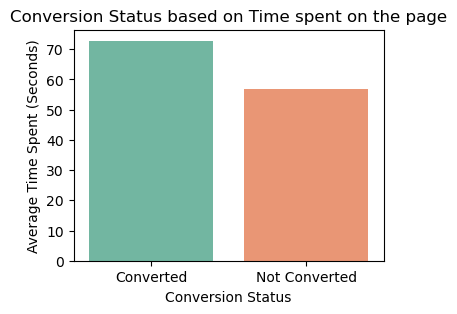

In [410]:
# Make a bar chart for better visualization

plt.figure(figsize=(4,3))
sns.barplot(x='conversion_status', y='time_spent', data=grouped_time, palette=CSet2)
plt.xlabel("Conversion Status")
plt.ylabel("Average Time Spent (Seconds)")
plt.title('Conversion Status based on Time spent on the page')
plt.show()

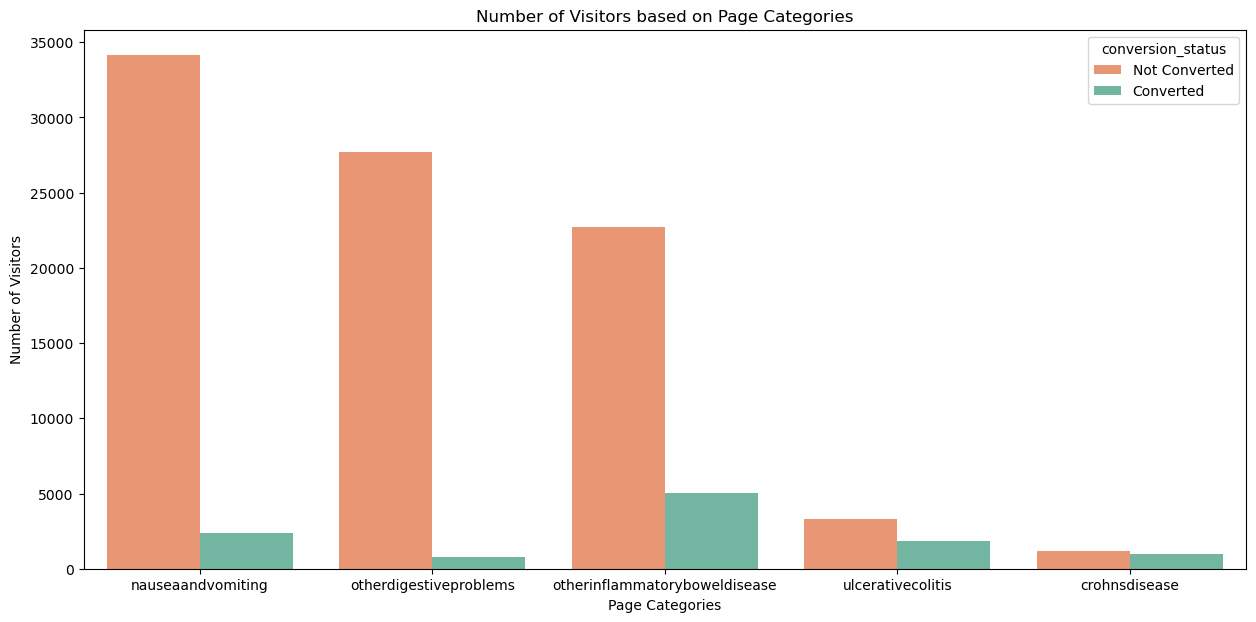

page_category
nauseaandvomiting                36475
otherdigestiveproblems           28475
otherinflammatoryboweldisease    27760
ulcerativecolitis                 5102
crohnsdisease                     2188
Name: count, dtype: int64


In [411]:
# Look into the number of bookings based on customer type
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,7))
sns.countplot(x='page_category', hue='conversion_status', data=health_df, ax=ax, palette=CSet2)

ax.set_ylabel("Number of Visitors")
ax.set_xlabel("Page Categories")
ax.set_title("Number of Visitors based on Page Categories")
plt.show()
# Provide the count
print(health_df.page_category.value_counts())

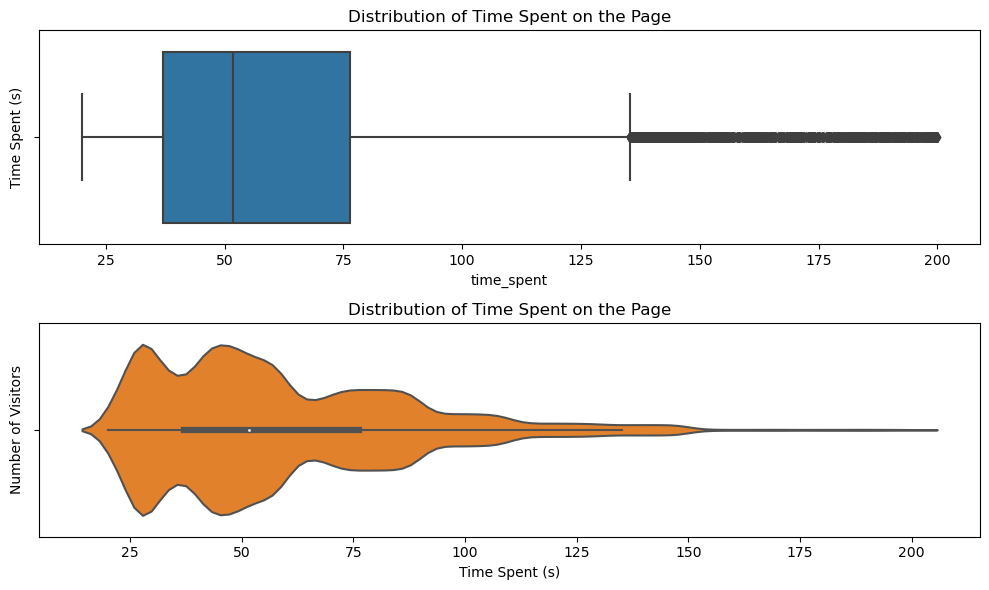

In [412]:
# Boxplots, violin plots, and more…
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(10, 6))
sns.boxplot(x='time_spent', data=health_df, color='C0',ax=ax[0])
ax[0].set_title('Distribution of Time Spent on the Page')
ax[0].set_ylabel('Number of Visitors')
ax[0].set_ylabel('Time Spent (s)')

sns.violinplot(x='time_spent', data=health_df, color='C1', ax=ax[1])
ax[1].set_title('Distribution of Time Spent on the Page')
ax[1].set_ylabel('Number of Visitors')
ax[1].set_xlabel('Time Spent (s)')

plt.tight_layout()
plt.show()

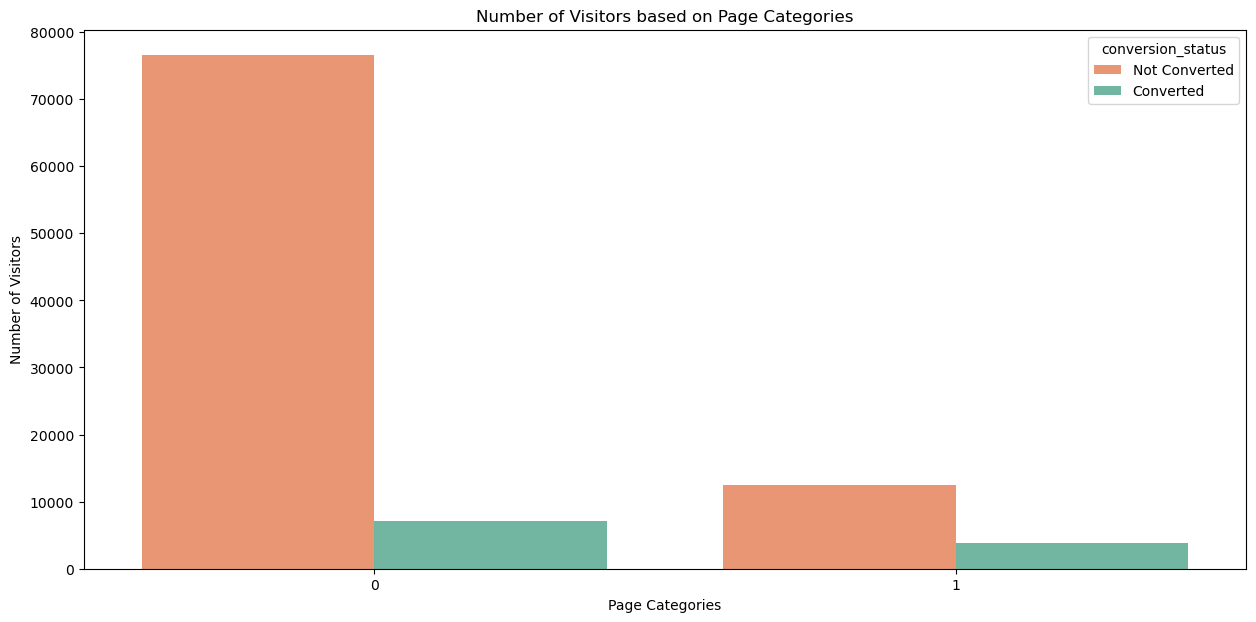

return_visitor
0    83629
1    16371
Name: count, dtype: int64


In [413]:
# Look into the number of bookings based on customer type
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,7))
sns.countplot(x='return_visitor', hue='conversion_status', data=health_df, ax=ax, palette=CSet2)

ax.set_ylabel("Number of Visitors")
ax.set_xlabel("Page Categories")
ax.set_title("Number of Visitors based on Page Categories")
plt.show()
# Provide the count
print(health_df.return_visitor.value_counts())

#### Conversion Rate for each Asset

In [415]:
conversion_by_dimensions = health_df.groupby(['asset_shown', 'known_diagnosis', 'page_category'])['conversion'].agg(['mean', 'count'])
sorted_conversion = conversion_by_dimensions.sort_values(by=['mean', 'count'], ascending=[False, False])

print(sorted_conversion)
print(conversion_by_dimensions)


                                                           mean  count
asset_shown known_diagnosis    page_category                          
C           Migraine           crohnsdisease           1.000000      2
            Breast Cancer      ulcerativecolitis       0.875000      8
A           Ulcerative Colitis crohnsdisease           0.692308     26
            Breast Cancer      crohnsdisease           0.666667      9
C           Depression         ulcerativecolitis       0.600000      5
...                                                         ...    ...
B           Breast Cancer      otherdigestiveproblems  0.000000    153
            Depression         otherdigestiveproblems  0.000000    148
            Migraine           otherdigestiveproblems  0.000000    140
            Crohns Disease     otherdigestiveproblems  0.000000     80
C           Migraine           ulcerativecolitis       0.000000      3

[90 rows x 2 columns]
                                                      

In [419]:
# Creating a table to see some of the meaningful combinations
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't wrap long strings
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

conversion_by_dimensions = health_df.groupby(['asset_shown', 'known_diagnosis', 'page_category'])['conversion'].agg(['mean', 'count'])
sorted_conversion = conversion_by_dimensions.sort_values(by=['mean', 'count'], ascending=[False, False])

print(sorted_conversion)
pd.reset_option('all')

                                                                  mean  count
asset_shown known_diagnosis    page_category                                 
C           Migraine           crohnsdisease                  1.000000      2
            Breast Cancer      ulcerativecolitis              0.875000      8
A           Ulcerative Colitis crohnsdisease                  0.692308     26
            Breast Cancer      crohnsdisease                  0.666667      9
C           Depression         ulcerativecolitis              0.600000      5
            Crohns Disease     ulcerativecolitis              0.571429      7
                               crohnsdisease                  0.553892    334
            Ulcerative Colitis ulcerativecolitis              0.551020     49
            Breast Cancer      crohnsdisease                  0.500000      4
                               ulcerativecolitis              0.477795    653
A           Crohns Disease     crohnsdisease                  0.

C:\Users\ngokh\AppData\Local\Temp\ipykernel_40760\240655345.py:11: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


### There are many interesting insights in result shown above. 
### For example, the combination of 'Asset A, Crohn’s Disease, Mobile' has a conversion rate of 0.4419, meaning that 44.19% of those with Crohn’s disease viewing Asset A on a desktop converted. The variation in converstion rates by device type seems negligible, therefore we can say that those with Crohn’s disease viewing Asset A will have a high conversion rate.

In [ ]:
revenue_per_conversion = {'A': 5, 'B': 7, 'C': 2.5}
health_df['revenue'] = health_df['asset_shown'].map(revenue_per_conversion) * health_df['conversion']

# Average revenue per conversion per asset
revenue_per_asset = health_df.groupby('asset_shown')['revenue'].mean()
print(revenue_per_asset)

asset_shown
A    0.548273
B    0.498909
C    0.426429
Name: revenue, dtype: float64


### Even though Asset C has the highest Conversion rate, its revenue per conversion is still lower than that of Asset A and Asset B due to lower price per unit. So I would recommend Asset A and Asset B to visitors with clearly good combination of features  above; for the rest of the users that we have limited information on, Asset C would be a much safer choice.